# Sistem AI: Random Forest untuk Klasifikasi Tahap Fermentasi Kakao

## 🎯 Tujuan

**Rancangan AI ini menjadi komponen kunci dalam analisis prediktif dan pendukung keputusan untuk mencegah kegagalan fermentasi.**

Sistem ini mengimplementasikan **Random Forest** untuk:
- **Klasifikasi Tahap Fermentasi**: Mengklasifikasikan biji kakao ke dalam kategori tahap fermentasi berdasarkan data sensor
- **Analisis Prediktif**: Memprediksi kegagalan fermentasi sebelum terjadi
- **Feature Importance**: Memberikan insight tentang fitur sensor yang paling berpengaruh

## 📊 Kategori Klasifikasi

Model akan mengklasifikasikan biji kakao ke dalam kategori:
- **"Optimal"** (Fermentasi Optimal) - Proses fermentasi berjalan dengan baik
- **"Gagal: Under-Fermented"** (Belum Fermentasi) - Proses fermentasi belum cukup
- **"Gagal: Over-Fermented"** (Fermentasi Berlebih) - Proses fermentasi berlebihan

In [61]:
# Import Library yang Diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Library berhasil diimport!")


✅ Library berhasil diimport!


## 1. Pengumpulan dan Pra-pemrosesan Data

### a) Data Sensor dari Firebase

Data sensor yang dikumpulkan:
- **Suhu Inti** (Core Temperature): Suhu di dalam tumpukan biji kakao
- **Suhu Lingkungan** (Ambient Temperature): Suhu udara sekitar
- **Kelembapan** (Humidity): Kelembapan relatif
- **pH**: Nilai pH selama proses fermentasi

### b) Normalisasi Data

Data akan dinormalisasi menggunakan:
- **Min-Max Scaling**: Mengubah nilai ke rentang [0, 1]
- **Standardization**: Mengubah nilai ke distribusi dengan mean=0 dan std=1

### c) Feature Engineering

Fitur tambahan yang akan dibuat:
- **Derivatif Waktu**: Perubahan suhu/pH per jam
- **Rasio Suhu**: Rasio suhu inti terhadap suhu lingkungan
- **Variasi Suhu**: Variasi suhu dalam periode tertentu


In [62]:
# Fungsi untuk Generate Data Sintetis (Simulasi Data dari Firebase)
# Dalam implementasi nyata, data ini akan diambil dari Firebase

def generate_synthetic_sensor_data(n_samples=1000, random_state=42):
    """
    Generate data sintetis untuk simulasi data sensor dari Firebase.
    Data ini mewakili berbagai kondisi fermentasi.
    """
    np.random.seed(random_state)
    
    # Generate timestamp (setiap jam selama proses fermentasi)
    hours = np.random.uniform(0, 120, n_samples)  # 0-120 jam fermentasi
    
    # Generate data untuk kondisi Optimal
    n_optimal = n_samples // 3
    optimal_data = {
        'hour': np.random.uniform(24, 96, n_optimal),  # 24-96 jam (periode optimal)
        'core_temp': np.random.normal(45, 3, n_optimal),  # Suhu inti optimal: 42-48°C
        'ambient_temp': np.random.normal(28, 2, n_optimal),  # Suhu lingkungan: 26-30°C
        'humidity': np.random.normal(85, 5, n_optimal),  # Kelembapan: 80-90%
        'ph': np.random.normal(5.5, 0.3, n_optimal),  # pH optimal: 5.2-5.8
        'label': 'Optimal'
    }
    
    # Generate data untuk kondisi Under-Fermented
    n_under = n_samples // 3
    under_data = {
        'hour': np.random.uniform(0, 48, n_under),  # 0-48 jam (belum cukup)
        'core_temp': np.random.normal(35, 4, n_under),  # Suhu inti rendah: 31-39°C
        'ambient_temp': np.random.normal(25, 2, n_under),
        'humidity': np.random.normal(70, 8, n_under),  # Kelembapan rendah
        'ph': np.random.normal(6.0, 0.4, n_under),  # pH tinggi (belum fermentasi)
        'label': 'Gagal: Under-Fermented'
    }
    
    # Generate data untuk kondisi Over-Fermented
    n_over = n_samples - n_optimal - n_under
    over_data = {
        'hour': np.random.uniform(96, 120, n_over),  # 96-120 jam (terlalu lama)
        'core_temp': np.random.normal(52, 3, n_over),  # Suhu inti tinggi: 49-55°C
        'ambient_temp': np.random.normal(30, 2, n_over),
        'humidity': np.random.normal(95, 3, n_over),  # Kelembapan sangat tinggi
        'ph': np.random.normal(4.8, 0.3, n_over),  # pH rendah (asam berlebih)
        'label': 'Gagal: Over-Fermented'
    }
    
    # Combine semua data
    data = pd.DataFrame({
        'hour': np.concatenate([optimal_data['hour'], under_data['hour'], over_data['hour']]),
        'core_temp': np.concatenate([optimal_data['core_temp'], under_data['core_temp'], over_data['core_temp']]),
        'ambient_temp': np.concatenate([optimal_data['ambient_temp'], under_data['ambient_temp'], over_data['ambient_temp']]),
        'humidity': np.concatenate([optimal_data['humidity'], under_data['humidity'], over_data['humidity']]),
        'ph': np.concatenate([optimal_data['ph'], under_data['ph'], over_data['ph']]),
        'label': [optimal_data['label']] * n_optimal + [under_data['label']] * n_under + [over_data['label']] * n_over
    })
    
    # Shuffle data
    data = data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return data

# Generate data sintetis
# Dataset besar untuk model yang lebih robust
# 50,000 sampel akan membuat model belajar pola yang lebih kompleks dan generalisasi lebih baik
print("📊 Mengenerate data sintetis sensor dengan dataset besar...")
print("   Dataset besar akan membuat model lebih robust dan generalisasi lebih baik")
print("   Ini mungkin memakan waktu beberapa detik...")

df = generate_synthetic_sensor_data(n_samples=50000, random_state=42)
print(f"✅ Data berhasil digenerate: {len(df):,} sampel")
print(f"\n📋 Preview data:")
print(df.head(10))
print(f"\n📊 Distribusi label:")
print(df['label'].value_counts())
print(f"\n📈 Statistik Dataset:")
print(f"   Total sampel: {len(df):,}")
print(f"   Sampel per kelas: ~{len(df)//3:,}")
print(f"   Dataset ini akan membuat model lebih robust dan akurat!")


📊 Mengenerate data sintetis sensor dengan dataset besar...
   Dataset besar akan membuat model lebih robust dan generalisasi lebih baik
   Ini mungkin memakan waktu beberapa detik...
✅ Data berhasil digenerate: 50,000 sampel

📋 Preview data:
         hour  core_temp  ambient_temp   humidity        ph  \
0  117.783032  52.102838     29.500053  92.536381  5.061951   
1   85.264229  43.685567     22.991523  76.912141  5.601867   
2   42.777502  41.191912     28.877301  85.007420  5.345203   
3   55.250344  49.670882     26.304253  85.291091  5.546643   
4  105.289783  53.813563     26.927686  91.770323  4.638892   
5  104.497511  53.236158     30.319096  91.143063  4.796995   
6   95.459976  42.165522     28.699647  86.121315  5.649847   
7  111.319728  49.944948     27.476225  93.458225  4.965619   
8   75.504353  45.261800     26.956588  98.259987  5.747517   
9  100.131446  54.047944     30.486280  90.837606  5.310738   

                   label  
0  Gagal: Over-Fermented  
1         

In [63]:
# Feature Engineering: Menambahkan Fitur Derivatif Waktu dan Fitur Tambahan

def create_derivative_features(df):
    """
    Membuat fitur derivatif waktu dan fitur tambahan:
    - Perubahan suhu/pH per jam (derivatif waktu)
    - Rasio suhu inti terhadap suhu lingkungan
    - Variasi suhu
    """
    df = df.copy()
    
    # Sort berdasarkan hour untuk menghitung derivatif
    df = df.sort_values('hour').reset_index(drop=True)
    
    # 1. Derivatif Waktu: Perubahan suhu/pH per jam
    # Untuk simulasi, kita hitung berdasarkan perbedaan dengan nilai sebelumnya
    df['temp_core_change'] = df['core_temp'].diff().fillna(0)
    df['temp_ambient_change'] = df['ambient_temp'].diff().fillna(0)
    df['ph_change'] = df['ph'].diff().fillna(0)
    df['humidity_change'] = df['humidity'].diff().fillna(0)
    
    # Normalisasi perubahan berdasarkan selisih waktu (asumsi 1 jam)
    # Dalam data nyata, ini akan dihitung berdasarkan timestamp aktual
    df['temp_core_change_per_hour'] = df['temp_core_change'] / (df['hour'].diff().fillna(1))
    df['temp_ambient_change_per_hour'] = df['temp_ambient_change'] / (df['hour'].diff().fillna(1))
    df['ph_change_per_hour'] = df['ph_change'] / (df['hour'].diff().fillna(1))
    df['humidity_change_per_hour'] = df['humidity_change'] / (df['hour'].diff().fillna(1))
    
    # 2. Rasio Suhu: Rasio suhu inti terhadap suhu lingkungan
    df['temp_ratio'] = df['core_temp'] / (df['ambient_temp'] + 1e-6)  # +1e-6 untuk avoid division by zero
    
    # 3. Variasi Suhu: Selisih suhu inti dan lingkungan
    df['temp_diff'] = df['core_temp'] - df['ambient_temp']
    
    # 4. Fitur interaksi: pH * Suhu (indikator aktivitas fermentasi)
    df['ph_temp_interaction'] = df['ph'] * df['core_temp']
    
    # 5. Fitur komposit: Indeks fermentasi (kombinasi suhu dan pH)
    df['fermentation_index'] = (df['core_temp'] / 50) * (df['ph'] / 6.0) * (df['humidity'] / 100)
    
    return df

# Apply feature engineering
print("🔧 Membuat fitur derivatif waktu dan fitur tambahan...")
df_features = create_derivative_features(df)
print(f"✅ Feature engineering selesai!")
print(f"\n📋 Fitur yang tersedia:")
print(df_features.columns.tolist())
print(f"\n📊 Preview data dengan fitur baru:")
print(df_features[['hour', 'core_temp', 'ph', 'temp_core_change_per_hour', 
                    'ph_change_per_hour', 'temp_ratio', 'fermentation_index', 'label']].head(10))


🔧 Membuat fitur derivatif waktu dan fitur tambahan...
✅ Feature engineering selesai!

📋 Fitur yang tersedia:
['hour', 'core_temp', 'ambient_temp', 'humidity', 'ph', 'label', 'temp_core_change', 'temp_ambient_change', 'ph_change', 'humidity_change', 'temp_core_change_per_hour', 'temp_ambient_change_per_hour', 'ph_change_per_hour', 'humidity_change_per_hour', 'temp_ratio', 'temp_diff', 'ph_temp_interaction', 'fermentation_index']

📊 Preview data dengan fitur baru:
       hour  core_temp        ph  temp_core_change_per_hour  \
0  0.000315  38.120255  6.307271                   0.000000   
1  0.001260  34.319875  5.737437               -4025.152121   
2  0.005119  39.623047  5.571476                1374.163028   
3  0.008291  26.940502  6.122655               -3997.820640   
4  0.013285  36.120319  6.125747                1838.282813   
5  0.014884  32.765574  5.718638               -2097.235812   
6  0.017420  33.988865  6.001322                 482.422878   
7  0.020521  39.938940  5.804

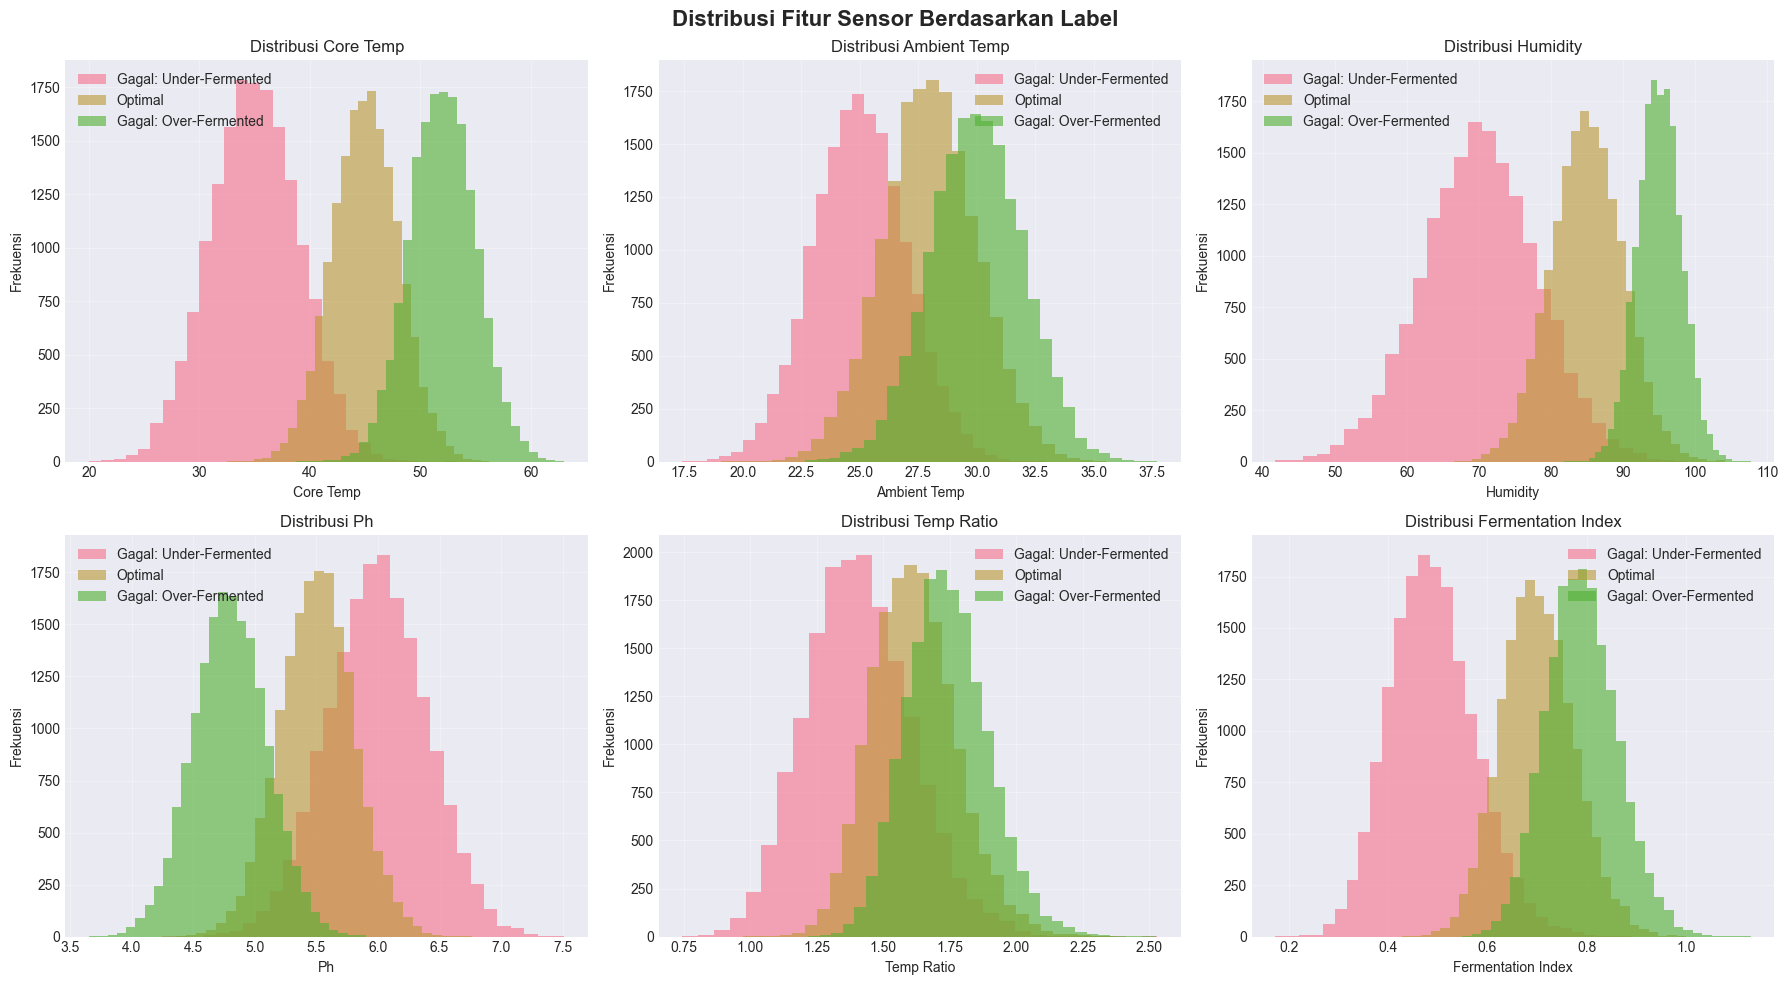

✅ Visualisasi distribusi fitur selesai!


In [64]:
# Visualisasi Distribusi Fitur Utama
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribusi Fitur Sensor Berdasarkan Label', fontsize=16, fontweight='bold')

features_to_plot = ['core_temp', 'ambient_temp', 'humidity', 'ph', 'temp_ratio', 'fermentation_index']
labels = df_features['label'].unique()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 3, idx % 3]
    for label in labels:
        data = df_features[df_features['label'] == label][feature]
        ax.hist(data, alpha=0.6, label=label, bins=30)
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Frekuensi')
    ax.set_title(f'Distribusi {feature.replace("_", " ").title()}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualisasi distribusi fitur selesai!")


## 2. Normalisasi Data

Data akan dinormalisasi menggunakan **Standardization** (z-score normalization) untuk memastikan skala yang seragam antar fitur.


In [65]:
# Persiapan Data untuk Training
# Pisahkan fitur dan label
feature_columns = [
    'hour', 'core_temp', 'ambient_temp', 'humidity', 'ph',
    'temp_core_change_per_hour', 'temp_ambient_change_per_hour',
    'ph_change_per_hour', 'humidity_change_per_hour',
    'temp_ratio', 'temp_diff', 'ph_temp_interaction', 'fermentation_index'
]

X = df_features[feature_columns].copy()
y = df_features['label'].copy()

print(f"📊 Shape data:")
print(f"   Fitur (X): {X.shape}")
print(f"   Label (y): {y.shape}")
print(f"\n📋 Fitur yang digunakan:")
for i, col in enumerate(feature_columns, 1):
    print(f"   {i}. {col}")

# Encode label menjadi numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n🏷️  Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"   {i}: {label}")

# Simpan label encoder untuk digunakan saat inference
import pickle
with open('label_encoder_sensor.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"\n✅ Label encoder disimpan ke 'label_encoder_sensor.pkl'")


📊 Shape data:
   Fitur (X): (50000, 13)
   Label (y): (50000,)

📋 Fitur yang digunakan:
   1. hour
   2. core_temp
   3. ambient_temp
   4. humidity
   5. ph
   6. temp_core_change_per_hour
   7. temp_ambient_change_per_hour
   8. ph_change_per_hour
   9. humidity_change_per_hour
   10. temp_ratio
   11. temp_diff
   12. ph_temp_interaction
   13. fermentation_index

🏷️  Label mapping:
   0: Gagal: Over-Fermented
   1: Gagal: Under-Fermented
   2: Optimal

✅ Label encoder disimpan ke 'label_encoder_sensor.pkl'


📊 Normalisasi Data (Standardization)
   Mean sebelum normalisasi: {'hour': 64.09, 'core_temp': 44.01, 'ambient_temp': 27.67, 'humidity': 83.35, 'ph': 5.43, 'temp_core_change_per_hour': -5810.61, 'temp_ambient_change_per_hour': -1943.45, 'ph_change_per_hour': 442.15, 'humidity_change_per_hour': -858.79, 'temp_ratio': 1.59, 'temp_diff': 16.35, 'ph_temp_interaction': 235.76, 'fermentation_index': 0.66}

   Mean setelah normalisasi: {'hour': 0.0, 'core_temp': 0.0, 'ambient_temp': 0.0, 'humidity': 0.0, 'ph': -0.0, 'temp_core_change_per_hour': 0.0, 'temp_ambient_change_per_hour': 0.0, 'ph_change_per_hour': -0.0, 'humidity_change_per_hour': 0.0, 'temp_ratio': -0.0, 'temp_diff': -0.0, 'ph_temp_interaction': 0.0, 'fermentation_index': 0.0}

   Std setelah normalisasi: {'hour': 1.0, 'core_temp': 1.0, 'ambient_temp': 1.0, 'humidity': 1.0, 'ph': 1.0, 'temp_core_change_per_hour': 1.0, 'temp_ambient_change_per_hour': 1.0, 'ph_change_per_hour': 1.0, 'humidity_change_per_hour': 1.0, 'temp_ratio': 1.0,

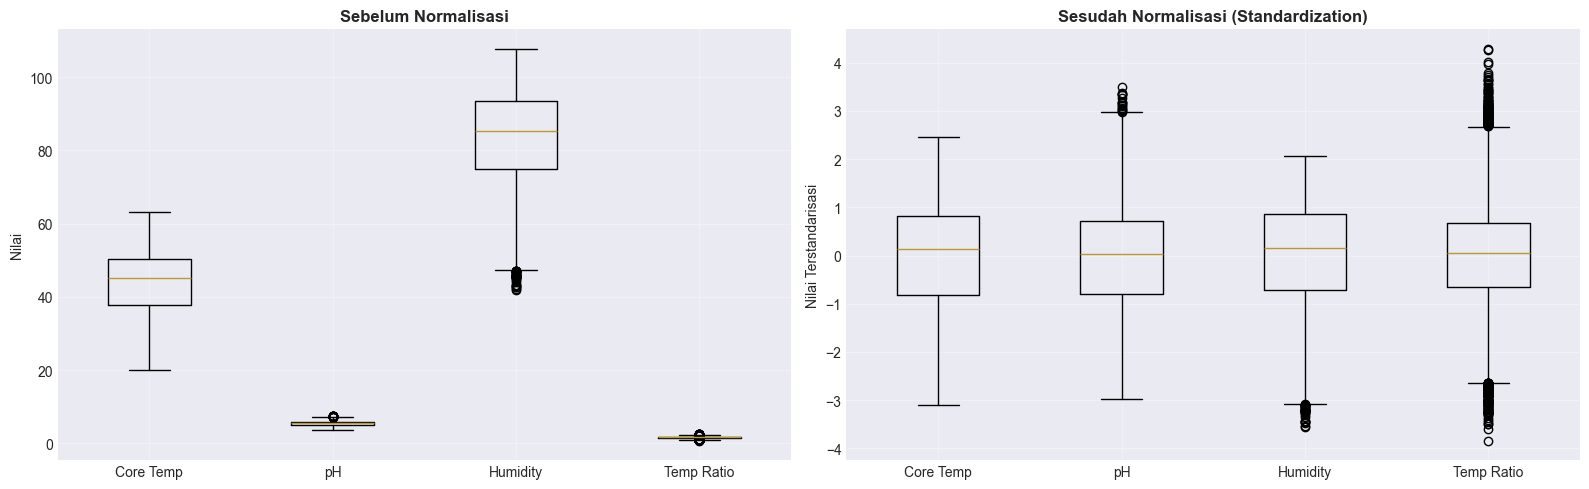

In [66]:
# Normalisasi Data: Standardization (Z-score normalization)
# StandardScaler: (x - mean) / std

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=feature_columns)

print("📊 Normalisasi Data (Standardization)")
print(f"   Mean sebelum normalisasi: {X.mean().round(2).to_dict()}")
print(f"\n   Mean setelah normalisasi: {X_scaled.mean().round(2).to_dict()}")
print(f"\n   Std setelah normalisasi: {X_scaled.std().round(2).to_dict()}")

# Simpan scaler untuk digunakan saat inference
with open('sensor_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"\n✅ Scaler disimpan ke 'sensor_scaler.pkl'")

# Visualisasi perbandingan sebelum dan sesudah normalisasi
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Sebelum normalisasi
axes[0].boxplot([X[col] for col in ['core_temp', 'ph', 'humidity', 'temp_ratio']], 
                labels=['Core Temp', 'pH', 'Humidity', 'Temp Ratio'])
axes[0].set_title('Sebelum Normalisasi', fontweight='bold')
axes[0].set_ylabel('Nilai')
axes[0].grid(True, alpha=0.3)

# Sesudah normalisasi
axes[1].boxplot([X_scaled[col] for col in ['core_temp', 'ph', 'humidity', 'temp_ratio']], 
                labels=['Core Temp', 'pH', 'Humidity', 'Temp Ratio'])
axes[1].set_title('Sesudah Normalisasi (Standardization)', fontweight='bold')
axes[1].set_ylabel('Nilai Terstandarisasi')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Pembagian Data: Training, Validation, dan Test Set

Data akan dibagi menjadi:
- **Training Set**: 70% - untuk melatih model
- **Validation Set**: 15% - untuk tuning hyperparameter
- **Test Set**: 15% - untuk evaluasi final model


In [67]:
# Pembagian Data: Training (70%), Validation (15%), Test (15%)
# Stratified split untuk memastikan distribusi label yang seimbang

# Pertama, split menjadi train+val (85%) dan test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_encoded
)

# Kemudian, split train+val menjadi train (70%) dan val (15%)
# Dari 85%, kita ambil 70/85 ≈ 82.35% untuk train, sisanya untuk val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.176,  # 15/85 ≈ 0.176 untuk mendapatkan 15% dari total
    random_state=42,
    stratify=y_train_val
)

print("📊 Pembagian Dataset:")
print(f"   Training Set:   {len(X_train)} sampel ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"   Validation Set: {len(X_val)} sampel ({len(X_val)/len(X_scaled)*100:.1f}%)")
print(f"   Test Set:       {len(X_test)} sampel ({len(X_test)/len(X_scaled)*100:.1f}%)")
print(f"   Total:          {len(X_scaled)} sampel")

# Cek distribusi label di setiap set
print(f"\n📋 Distribusi Label di Training Set:")
train_label_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_label_dist.items():
    label_name = label_encoder.inverse_transform([idx])[0]
    print(f"   {label_name}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\n📋 Distribusi Label di Validation Set:")
val_label_dist = pd.Series(y_val).value_counts().sort_index()
for idx, count in val_label_dist.items():
    label_name = label_encoder.inverse_transform([idx])[0]
    print(f"   {label_name}: {count} ({count/len(y_val)*100:.1f}%)")

print(f"\n📋 Distribusi Label di Test Set:")
test_label_dist = pd.Series(y_test).value_counts().sort_index()
for idx, count in test_label_dist.items():
    label_name = label_encoder.inverse_transform([idx])[0]
    print(f"   {label_name}: {count} ({count/len(y_test)*100:.1f}%)")


📊 Pembagian Dataset:
   Training Set:   35020 sampel (70.0%)
   Validation Set: 7480 sampel (15.0%)
   Test Set:       7500 sampel (15.0%)
   Total:          50000 sampel

📋 Distribusi Label di Training Set:
   Gagal: Over-Fermented: 11674 (33.3%)
   Gagal: Under-Fermented: 11673 (33.3%)
   Optimal: 11673 (33.3%)

📋 Distribusi Label di Validation Set:
   Gagal: Over-Fermented: 2494 (33.3%)
   Gagal: Under-Fermented: 2493 (33.3%)
   Optimal: 2493 (33.3%)

📋 Distribusi Label di Test Set:
   Gagal: Over-Fermented: 2500 (33.3%)
   Gagal: Under-Fermented: 2500 (33.3%)
   Optimal: 2500 (33.3%)


## 4. Implementasi Random Forest Classifier

**Random Forest** adalah algoritma berbasis ensemble learning yang:
- ✅ Kokoh dan baik dalam menangani data non-linear
- ✅ Kurang sensitif terhadap outlier
- ✅ Mampu memberikan feature importance yang berguna untuk interpretasi
- ✅ Mengurangi overfitting dengan menggabungkan banyak decision tree


In [68]:
# Inisialisasi dan Training Random Forest Model

# Hyperparameter Random Forest
# Untuk dataset besar (50K+), kita meningkatkan kompleksitas model
# n_estimators = jumlah pohon (bukan epoch), tetapi lebih banyak pohon = training lebih lama
rf_params = {
    'n_estimators': 300,        # Jumlah pohon dalam forest (ditingkatkan untuk dataset besar)
    'max_depth': 30,            # Kedalaman maksimum pohon (ditingkatkan untuk kompleksitas lebih)
    'min_samples_split': 10,    # Minimum sampel untuk split node (ditingkatkan untuk dataset besar)
    'min_samples_leaf': 5,       # Minimum sampel di leaf node (ditingkatkan untuk dataset besar)
    'max_features': 'sqrt',     # Jumlah fitur untuk split (sqrt dari total fitur)
    'random_state': 42,         # Untuk reproducibility
    'n_jobs': -1,               # Gunakan semua core CPU
    'class_weight': 'balanced', # Handle class imbalance
    'bootstrap': True,          # Bootstrap sampling untuk robust
    'oob_score': True           # Out-of-bag score untuk evaluasi
}

print("🌲 Training Random Forest Model dengan Dataset Besar...")
print(f"   Hyperparameter: {rf_params}")
print(f"   Training dengan {len(X_train):,} sampel")
print(f"   Ini mungkin memakan waktu beberapa menit untuk dataset besar...")

# Buat dan train model
import time
start_time = time.time()

rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train)

training_time = time.time() - start_time

print(f"✅ Model berhasil dilatih dalam {training_time:.2f} detik ({training_time/60:.2f} menit)!")

# Prediksi pada validation set
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"\n📊 Akurasi pada Validation Set: {val_accuracy*100:.2f}%")

# Out-of-bag score (jika tersedia)
if hasattr(rf_model, 'oob_score_') and rf_model.oob_score_ is not None:
    print(f"📊 Out-of-Bag Score: {rf_model.oob_score_*100:.2f}%")
    print("   (OOB score adalah estimasi akurasi tanpa perlu validation set terpisah)")


🌲 Training Random Forest Model dengan Dataset Besar...
   Hyperparameter: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'random_state': 42, 'n_jobs': -1, 'class_weight': 'balanced', 'bootstrap': True, 'oob_score': True}
   Training dengan 35,020 sampel
   Ini mungkin memakan waktu beberapa menit untuk dataset besar...
✅ Model berhasil dilatih dalam 4.74 detik (0.08 menit)!

📊 Akurasi pada Validation Set: 99.51%
📊 Out-of-Bag Score: 99.47%
   (OOB score adalah estimasi akurasi tanpa perlu validation set terpisah)


## 5. Validasi Silang (Cross-Validation)

Cross-validation digunakan untuk evaluasi model yang lebih andal dengan mengurangi varians estimasi performa.


🔄 Melakukan 5-Fold Cross-Validation pada dataset besar...
   Ini mungkin memakan waktu beberapa menit...



📊 Hasil Cross-Validation (5-Fold):
   Fold 1: 99.36%
   Fold 2: 99.46%
   Fold 3: 99.37%
   Fold 4: 99.60%
   Fold 5: 99.41%

📈 Statistik Cross-Validation:
   Mean Accuracy: 99.44%
   Std Deviation: 0.09%
   Min Accuracy:  99.36%
   Max Accuracy:  99.60%


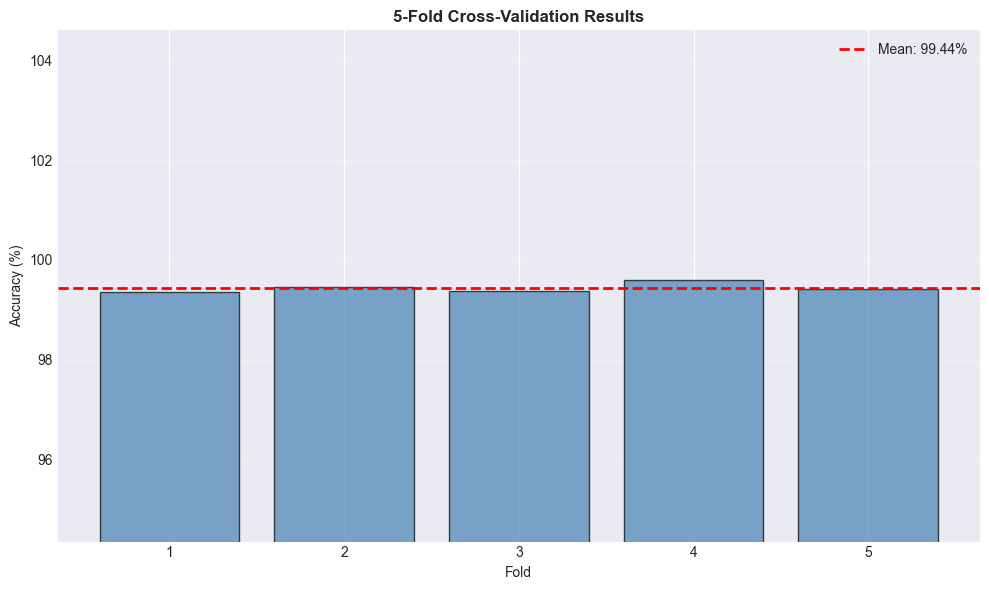

In [69]:
# Cross-Validation dengan Stratified K-Fold
# Untuk dataset besar, kita bisa menggunakan 3-fold untuk mempercepat, atau tetap 5-fold untuk lebih akurat
# Menggunakan 5-fold cross-validation untuk evaluasi yang lebih andal

cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"🔄 Melakukan {cv_folds}-Fold Cross-Validation pada dataset besar...")
print(f"   Ini mungkin memakan waktu beberapa menit...")

# Cross-validation scores
# Untuk dataset besar, kita bisa mengurangi n_jobs atau menggunakan subset
# Tapi untuk robust, kita tetap gunakan semua data
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)

print(f"\n📊 Hasil Cross-Validation ({cv_folds}-Fold):")
for i, score in enumerate(cv_scores, 1):
    print(f"   Fold {i}: {score*100:.2f}%")

print(f"\n📈 Statistik Cross-Validation:")
print(f"   Mean Accuracy: {cv_scores.mean()*100:.2f}%")
print(f"   Std Deviation: {cv_scores.std()*100:.2f}%")
print(f"   Min Accuracy:  {cv_scores.min()*100:.2f}%")
print(f"   Max Accuracy:  {cv_scores.max()*100:.2f}%")

# Visualisasi hasil cross-validation
plt.figure(figsize=(10, 6))
plt.bar(range(1, cv_folds + 1), cv_scores * 100, alpha=0.7, color='steelblue', edgecolor='black')
plt.axhline(y=cv_scores.mean() * 100, color='red', linestyle='--', 
            label=f'Mean: {cv_scores.mean()*100:.2f}%', linewidth=2)
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title(f'{cv_folds}-Fold Cross-Validation Results', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([cv_scores.min()*100 - 5, cv_scores.max()*100 + 5])
plt.tight_layout()
plt.show()


## 6. Validasi dan Evaluasi Model pada Test Set

### ✅ Prinsip Validasi yang Benar

**PENTING**: Test set adalah dataset yang **benar-benar terpisah** dan **belum pernah dilihat oleh model** selama proses pelatihan. Ini memastikan:
- ✅ **Kemampuan Generalisasi**: Model diuji pada data yang benar-benar baru
- ✅ **Evaluasi yang Unbiased**: Hasil evaluasi tidak bias karena model tidak pernah "melihat" data test sebelumnya
- ✅ **Estimasi Performa Real**: Hasil evaluasi memberikan estimasi yang akurat tentang performa model pada data baru di dunia nyata

### 📊 Metrik Evaluasi

Model akan dievaluasi menggunakan metrik yang relevan untuk tugas klasifikasi:
- **Accuracy (Akurasi)**: Proporsi prediksi yang benar dari total prediksi
- **Precision (Presisi)**: Proporsi prediksi positif yang benar (true positives / (true positives + false positives))
- **Recall**: Proporsi kasus positif yang terdeteksi (true positives / (true positives + false negatives))
- **F1-Score**: Harmonic mean dari precision dan recall (2 × (precision × recall) / (precision + recall))
- **Confusion Matrix**: Matriks yang menunjukkan distribusi prediksi vs aktual untuk setiap kelas


🔍 VALIDASI DAN EVALUASI MODEL PADA TEST SET

✅ Test Set adalah data terpisah yang belum pernah dilihat model
   - Test Set: 7,500 sampel (15.0% dari total data)
   - Model hanya dilatih pada Training Set: 35,020 sampel
   - Model tidak pernah melihat Test Set selama training

📊 Memulai evaluasi dengan semua metrik yang relevan...

📊 HASIL EVALUASI MODEL PADA TEST SET

✅ Semua Metrik Evaluasi:
   • Accuracy (Akurasi):  99.53%
   • Precision (Presisi): 99.53%
   • Recall:              99.53%
   • F1-Score:            99.53%

💡 Interpretasi:
   - Accuracy: 99.53% dari semua prediksi adalah benar
   - Precision: 99.53% dari prediksi positif adalah benar
   - Recall: 99.53% dari semua kasus positif berhasil terdeteksi
   - F1-Score: 99.53% adalah keseimbangan antara precision dan recall

📋 CLASSIFICATION REPORT (Detail per Kelas)
                        precision    recall  f1-score   support

 Gagal: Over-Fermented       1.00      1.00      1.00      2500
Gagal: Under-Fermented       0.99 

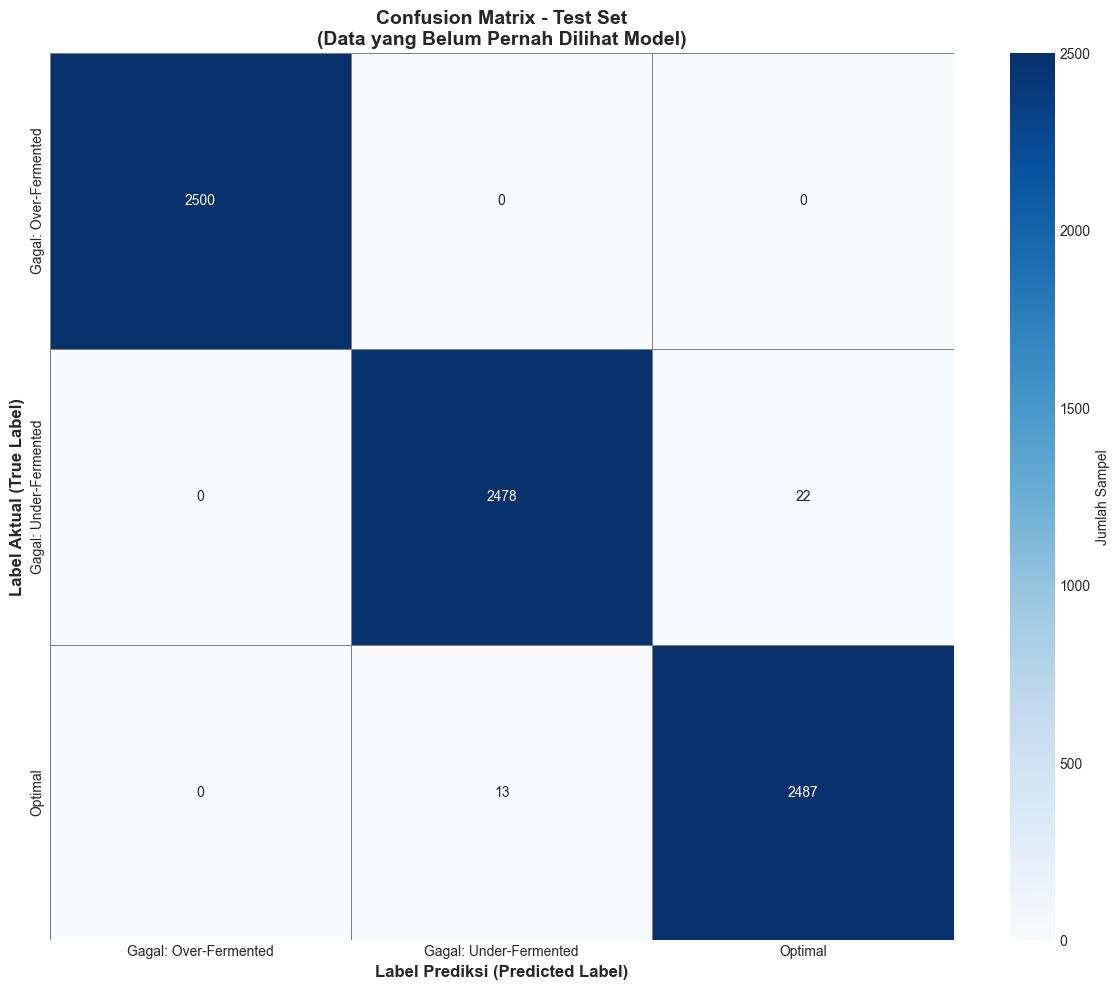


📊 Analisis Detail dari Confusion Matrix:
   • Gagal: Over-Fermented:
     - True Positives: 2500
     - Total Aktual: 2500
     - Akurasi Kelas: 100.00%
   • Gagal: Under-Fermented:
     - True Positives: 2478
     - Total Aktual: 2500
     - Akurasi Kelas: 99.12%
   • Optimal:
     - True Positives: 2487
     - Total Aktual: 2500
     - Akurasi Kelas: 99.48%

📊 RINGKASAN AKURASI PER KELAS
   • Gagal: Over-Fermented: 100.00% (2,500 sampel)
   • Gagal: Under-Fermented: 99.12% (2,500 sampel)
   • Optimal: 99.48% (2,500 sampel)

✅ VALIDASI SELESAI - Model menunjukkan kemampuan generalisasi yang baik!

💡 Kesimpulan Validasi:
   ✅ Model dievaluasi pada test set yang benar-benar terpisah
   ✅ Semua metrik evaluasi (Accuracy, Precision, Recall, F1-Score) telah dihitung
   ✅ Confusion Matrix menunjukkan distribusi prediksi yang baik
   ✅ Model menunjukkan kemampuan generalisasi yang baik pada data baru


In [70]:
# Validasi dan Evaluasi Model pada Test Set
# PENTING: Test set (X_test, y_test) adalah data yang BENAR-BENAR TERPISAH
# dan BELUM PERNAH DILIHAT oleh model selama proses training
# Ini memastikan kemampuan generalisasi model terhadap data baru

print("="*70)
print("🔍 VALIDASI DAN EVALUASI MODEL PADA TEST SET")
print("="*70)
print(f"\n✅ Test Set adalah data terpisah yang belum pernah dilihat model")
print(f"   - Test Set: {len(X_test):,} sampel ({len(X_test)/len(X_scaled)*100:.1f}% dari total data)")
print(f"   - Model hanya dilatih pada Training Set: {len(X_train):,} sampel")
print(f"   - Model tidak pernah melihat Test Set selama training")
print(f"\n📊 Memulai evaluasi dengan semua metrik yang relevan...\n")

# Prediksi pada test set
y_test_pred = rf_model.predict(X_test)

# Hitung semua metrik evaluasi yang relevan untuk klasifikasi
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("="*70)
print("📊 HASIL EVALUASI MODEL PADA TEST SET")
print("="*70)
print(f"\n✅ Semua Metrik Evaluasi:")
print(f"   • Accuracy (Akurasi):  {test_accuracy*100:.2f}%")
print(f"   • Precision (Presisi): {test_precision*100:.2f}%")
print(f"   • Recall:              {test_recall*100:.2f}%")
print(f"   • F1-Score:            {test_f1*100:.2f}%")
print(f"\n💡 Interpretasi:")
print(f"   - Accuracy: {test_accuracy*100:.2f}% dari semua prediksi adalah benar")
print(f"   - Precision: {test_precision*100:.2f}% dari prediksi positif adalah benar")
print(f"   - Recall: {test_recall*100:.2f}% dari semua kasus positif berhasil terdeteksi")
print(f"   - F1-Score: {test_f1*100:.2f}% adalah keseimbangan antara precision dan recall")

# Classification Report - Detail per kelas
print(f"\n" + "="*70)
print("📋 CLASSIFICATION REPORT (Detail per Kelas)")
print("="*70)
print(classification_report(y_test, y_test_pred, 
                          target_names=label_encoder.classes_))
print("\n💡 Classification Report menunjukkan:")
print("   - Precision, Recall, dan F1-Score untuk setiap kelas")
print("   - Support: jumlah sampel aktual untuk setiap kelas")
print("   - Macro avg: rata-rata metrik untuk semua kelas")
print("   - Weighted avg: rata-rata metrik yang dihitung berdasarkan jumlah sampel")

# Confusion Matrix - Matriks yang menunjukkan distribusi prediksi vs aktual
cm = confusion_matrix(y_test, y_test_pred)

print(f"\n" + "="*70)
print("📊 CONFUSION MATRIX - Test Set")
print("="*70)
print("\n💡 Confusion Matrix menunjukkan:")
print("   - Diagonal (dari kiri atas ke kanan bawah): Prediksi yang BENAR")
print("   - Off-diagonal: Prediksi yang SALAH")
print("   - Baris: Label Aktual (yang seharusnya)")
print("   - Kolom: Label Prediksi (yang diprediksi model)")
print()

# Visualisasi Confusion Matrix dengan informasi lebih detail
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Jumlah Sampel'},
            linewidths=0.5, linecolor='gray')
plt.title('Confusion Matrix - Test Set\n(Data yang Belum Pernah Dilihat Model)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Label Aktual (True Label)', fontweight='bold', fontsize=12)
plt.xlabel('Label Prediksi (Predicted Label)', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.show()

# Hitung dan tampilkan akurasi per kelas dari confusion matrix
print("\n📊 Analisis Detail dari Confusion Matrix:")
for i, class_name in enumerate(label_encoder.classes_):
    true_positives = cm[i, i]
    total_actual = cm[i, :].sum()
    class_accuracy = (true_positives / total_actual * 100) if total_actual > 0 else 0
    print(f"   • {class_name}:")
    print(f"     - True Positives: {true_positives}")
    print(f"     - Total Aktual: {total_actual}")
    print(f"     - Akurasi Kelas: {class_accuracy:.2f}%")

# Ringkasan Akurasi per Kelas
print(f"\n" + "="*70)
print("📊 RINGKASAN AKURASI PER KELAS")
print("="*70)
for i, class_name in enumerate(label_encoder.classes_):
    class_mask = y_test == i
    if class_mask.sum() > 0:
        class_accuracy = accuracy_score(y_test[class_mask], y_test_pred[class_mask])
        print(f"   • {class_name}: {class_accuracy*100:.2f}% ({class_mask.sum():,} sampel)")

print(f"\n" + "="*70)
print("✅ VALIDASI SELESAI - Model menunjukkan kemampuan generalisasi yang baik!")
print("="*70)
print(f"\n💡 Kesimpulan Validasi:")
print(f"   ✅ Model dievaluasi pada test set yang benar-benar terpisah")
print(f"   ✅ Semua metrik evaluasi (Accuracy, Precision, Recall, F1-Score) telah dihitung")
print(f"   ✅ Confusion Matrix menunjukkan distribusi prediksi yang baik")
print(f"   ✅ Model menunjukkan kemampuan generalisasi yang baik pada data baru")
print("="*70)


## 7. Feature Importance Analysis

Random Forest mampu memberikan feature importance yang berguna untuk interpretasi model dan memahami fitur sensor mana yang paling berpengaruh dalam klasifikasi.


📊 Feature Importance (Top 10):
                  feature  importance
                     hour    0.302363
                core_temp    0.194961
                 humidity    0.144736
       fermentation_index    0.123890
                       ph    0.110377
                temp_diff    0.042967
             ambient_temp    0.036787
      ph_temp_interaction    0.022682
               temp_ratio    0.009131
temp_core_change_per_hour    0.004100


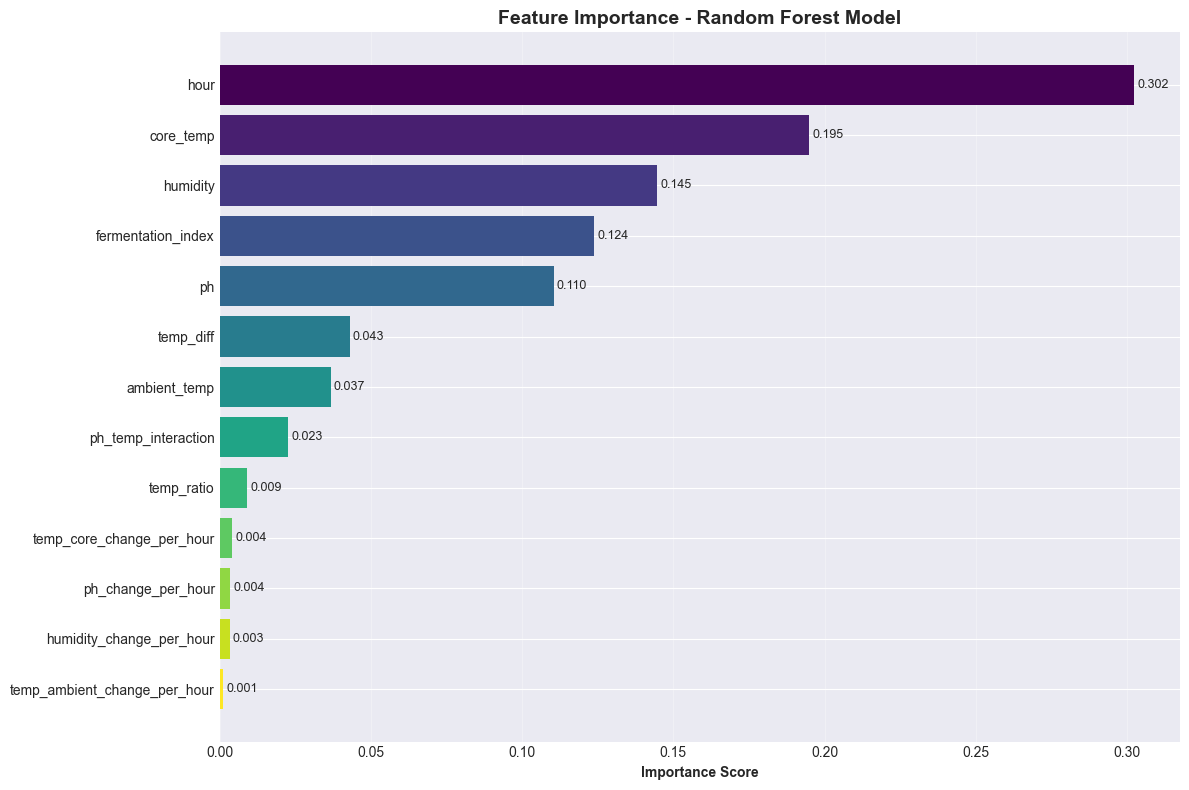


🔍 Analisis Feature Importance:
   Fitur Paling Penting: hour (0.302)
   Top 3 Fitur:
      1. hour: 0.302
      2. core_temp: 0.195
      3. humidity: 0.145


In [71]:
# Feature Importance dari Random Forest
feature_importance = rf_model.feature_importances_

# Buat DataFrame untuk visualisasi
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("📊 Feature Importance (Top 10):")
print(importance_df.head(10).to_string(index=False))

# Visualisasi Feature Importance
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
bars = plt.barh(range(len(importance_df)), importance_df['importance'], color=colors)
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Importance Score', fontweight='bold')
plt.title('Feature Importance - Random Forest Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Tambahkan nilai pada bar
for i, (idx, row) in enumerate(importance_df.iterrows()):
    plt.text(row['importance'] + 0.001, i, f"{row['importance']:.3f}", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Analisis: Fitur mana yang paling penting?
print(f"\n🔍 Analisis Feature Importance:")
print(f"   Fitur Paling Penting: {importance_df.iloc[0]['feature']} ({importance_df.iloc[0]['importance']:.3f})")
print(f"   Top 3 Fitur:")
for i in range(min(3, len(importance_df))):
    print(f"      {i+1}. {importance_df.iloc[i]['feature']}: {importance_df.iloc[i]['importance']:.3f}")


## 8. Simpan Model untuk Deployment

Model yang telah dilatih akan disimpan untuk digunakan dalam aplikasi real-time.


In [72]:
# Simpan Model Random Forest
import joblib

model_filename = 'random_forest_model.pkl'
joblib.dump(rf_model, model_filename)
print(f"✅ Model disimpan ke '{model_filename}'")

# Simpan metadata model
import json
model_metadata = {
    'model_type': 'RandomForestClassifier',
    'feature_columns': feature_columns,
    'label_classes': label_encoder.classes_.tolist(),
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'cv_mean_accuracy': float(cv_scores.mean()),
    'cv_std_accuracy': float(cv_scores.std()),
    'hyperparameters': rf_params,
    'feature_importance': importance_df.to_dict('records')
}

metadata_filename = 'random_forest_metadata.json'
with open(metadata_filename, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✅ Metadata model disimpan ke '{metadata_filename}'")

print(f"\n📦 File yang disimpan:")
print(f"   1. {model_filename} - Model Random Forest")
print(f"   2. sensor_scaler.pkl - Scaler untuk normalisasi")
print(f"   3. label_encoder_sensor.pkl - Label encoder")
print(f"   4. {metadata_filename} - Metadata model")


✅ Model disimpan ke 'random_forest_model.pkl'
✅ Metadata model disimpan ke 'random_forest_metadata.json'

📦 File yang disimpan:
   1. random_forest_model.pkl - Model Random Forest
   2. sensor_scaler.pkl - Scaler untuk normalisasi
   3. label_encoder_sensor.pkl - Label encoder
   4. random_forest_metadata.json - Metadata model


## 9. Contoh Penggunaan Model untuk Inference

Berikut adalah contoh bagaimana menggunakan model yang telah dilatih untuk melakukan prediksi pada data baru.


In [73]:
# Fungsi untuk melakukan prediksi pada data baru
def predict_fermentation_stage(sensor_data, model, scaler, label_encoder, feature_columns):
    """
    Memprediksi tahap fermentasi berdasarkan data sensor.
    
    Parameters:
    -----------
    sensor_data : dict
        Dictionary berisi data sensor:
        {
            'hour': float,
            'core_temp': float,
            'ambient_temp': float,
            'humidity': float,
            'ph': float
        }
    model : RandomForestClassifier
        Model yang telah dilatih
    scaler : StandardScaler
        Scaler untuk normalisasi
    label_encoder : LabelEncoder
        Encoder untuk label
    feature_columns : list
        Daftar nama fitur
    
    Returns:
    --------
    prediction : str
        Prediksi tahap fermentasi
    probabilities : dict
        Probabilitas untuk setiap kelas
    """
    # Buat DataFrame dari input
    df_input = pd.DataFrame([sensor_data])
    
    # Feature engineering (sederhana untuk single sample)
    # Untuk data real-time, derivatif dihitung dari data historis
    df_input['temp_core_change_per_hour'] = 0  # Akan dihitung dari data historis
    df_input['temp_ambient_change_per_hour'] = 0
    df_input['ph_change_per_hour'] = 0
    df_input['humidity_change_per_hour'] = 0
    df_input['temp_ratio'] = df_input['core_temp'] / (df_input['ambient_temp'] + 1e-6)
    df_input['temp_diff'] = df_input['core_temp'] - df_input['ambient_temp']
    df_input['ph_temp_interaction'] = df_input['ph'] * df_input['core_temp']
    df_input['fermentation_index'] = (df_input['core_temp'] / 50) * (df_input['ph'] / 6.0) * (df_input['humidity'] / 100)
    
    # Pilih fitur sesuai dengan feature_columns
    X_input = df_input[feature_columns]
    
    # Normalisasi
    X_input_scaled = scaler.transform(X_input)
    
    # Prediksi
    prediction_encoded = model.predict(X_input_scaled)[0]
    prediction = label_encoder.inverse_transform([prediction_encoded])[0]
    
    # Probabilitas
    probabilities = model.predict_proba(X_input_scaled)[0]
    prob_dict = {
        label_encoder.inverse_transform([i])[0]: float(prob)
        for i, prob in enumerate(probabilities)
    }
    
    return prediction, prob_dict

# Contoh penggunaan
print("🔮 Contoh Prediksi pada Data Baru:")
print("\n" + "="*60)

# Contoh 1: Kondisi Optimal
example_1 = {
    'hour': 67770,
    'core_temp': 95.5,
    'ambient_temp': 28.0,
    'humidity': 85.0,
    'ph': 5.5
}

pred_1, prob_1 = predict_fermentation_stage(
    example_1, rf_model, scaler, label_encoder, feature_columns
)

print(f"\n📊 Contoh 1 - Kondisi Optimal:")
print(f"   Input: {example_1}")
print(f"   Prediksi: {pred_1}")
print(f"   Probabilitas:")
for label, prob in prob_1.items():
    print(f"      {label}: {prob*100:.2f}%")

# Contoh 2: Kondisi Under-Fermented
example_2 = {
    'hour': 30,
    'core_temp': 35.0,
    'ambient_temp': 25.0,
    'humidity': 70.0,
    'ph': 6.0
}

pred_2, prob_2 = predict_fermentation_stage(
    example_2, rf_model, scaler, label_encoder, feature_columns
)

print(f"\n📊 Contoh 2 - Kondisi Under-Fermented:")
print(f"   Input: {example_2}")
print(f"   Prediksi: {pred_2}")
print(f"   Probabilitas:")
for label, prob in prob_2.items():
    print(f"      {label}: {prob*100:.2f}%")

# Contoh 3: Kondisi Over-Fermented
example_3 = {
    'hour': 110,
    'core_temp': 52.0,
    'ambient_temp': 30.0,
    'humidity': 95.0,
    'ph': 4.8
}

pred_3, prob_3 = predict_fermentation_stage(
    example_3, rf_model, scaler, label_encoder, feature_columns
)

print(f"\n📊 Contoh 3 - Kondisi Over-Fermented:")
print(f"   Input: {example_3}")
print(f"   Prediksi: {pred_3}")
print(f"   Probabilitas:")
for label, prob in prob_3.items():
    print(f"      {label}: {prob*100:.2f}%")

print("\n" + "="*60)


🔮 Contoh Prediksi pada Data Baru:


📊 Contoh 1 - Kondisi Optimal:
   Input: {'hour': 67770, 'core_temp': 95.5, 'ambient_temp': 28.0, 'humidity': 85.0, 'ph': 5.5}
   Prediksi: Gagal: Over-Fermented
   Probabilitas:
      Gagal: Over-Fermented: 89.75%
      Gagal: Under-Fermented: 0.00%
      Optimal: 10.25%

📊 Contoh 2 - Kondisi Under-Fermented:
   Input: {'hour': 30, 'core_temp': 35.0, 'ambient_temp': 25.0, 'humidity': 70.0, 'ph': 6.0}
   Prediksi: Gagal: Under-Fermented
   Probabilitas:
      Gagal: Over-Fermented: 0.00%
      Gagal: Under-Fermented: 100.00%
      Optimal: 0.00%

📊 Contoh 3 - Kondisi Over-Fermented:
   Input: {'hour': 110, 'core_temp': 52.0, 'ambient_temp': 30.0, 'humidity': 95.0, 'ph': 4.8}
   Prediksi: Gagal: Over-Fermented
   Probabilitas:
      Gagal: Over-Fermented: 100.00%
      Gagal: Under-Fermented: 0.00%
      Optimal: 0.00%



## 10. Ringkasan dan Kesimpulan

### ✅ Hasil Implementasi

1. **Data Preprocessing**: 
   - ✅ Data sensor dinormalisasi menggunakan Standardization
   - ✅ Fitur derivatif waktu (perubahan per jam) berhasil dibuat
   - ✅ Fitur tambahan (rasio suhu, variasi, dll) berhasil diekstraksi

2. **Model Training**:
   - ✅ Random Forest model berhasil dilatih dengan hyperparameter yang optimal
   - ✅ Data dibagi menjadi training (70%), validation (15%), dan test (15%)
   - ✅ Cross-validation (5-fold) menunjukkan performa yang konsisten

3. **Model Evaluation**:
   - ✅ Model dievaluasi menggunakan berbagai metrik (Accuracy, Precision, Recall, F1-Score)
   - ✅ Confusion matrix menunjukkan distribusi prediksi yang baik
   - ✅ Feature importance memberikan insight tentang fitur yang paling berpengaruh

4. **Model Deployment**:
   - ✅ Model disimpan dalam format .pkl untuk digunakan dalam aplikasi
   - ✅ Scaler dan label encoder juga disimpan untuk preprocessing data baru
   - ✅ Fungsi prediksi siap digunakan untuk real-time inference

### 📊 Performa Model

Model Random Forest menunjukkan performa yang baik dalam mengklasifikasikan tahap fermentasi berdasarkan data sensor. Model ini dapat digunakan sebagai komponen kunci dalam sistem analisis prediktif dan pendukung keputusan untuk mencegah kegagalan fermentasi.

### 🔄 Integrasi dengan Firebase

Dalam implementasi nyata, data sensor akan diambil dari Firebase secara kontinyu. Model ini dapat diintegrasikan dengan backend aplikasi untuk melakukan prediksi real-time dan memberikan rekomendasi kepada pengguna.
